In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

In [2]:
dataset_path = Path("/Users/mkurtys/datasets/spine")

In [3]:
condition_severity_map = {
    "Normal/Mild": 0,
    "Moderate": 1,
    "Severe": 2
}

level_code_map = {
    "l1_l2": 0,
    "l2_l3": 1,
    "l3_l4": 2,
    "l4_l5": 3,
    "l5_s1": 4
}

conditions_unsided = {
    'neural_foraminal_narrowing',
    'subarticular_stenosis'
    'spinal_canal_stenosis'
}

descriptions = pd.read_csv(dataset_path/"train_series_descriptions.csv")
coordinates = pd.read_csv(dataset_path/"train_label_coordinates.csv")
submissions = pd.read_csv(dataset_path/"sample_submission.csv")
train = pd.read_csv(dataset_path/"train.csv")

train_melt = train.melt(id_vars="study_id", var_name="condition_spec", value_name="severity").sort_values(["study_id", "condition_spec"])
train_melt["severity_code"] = train_melt["severity"].map(condition_severity_map)
train_melt["level"] = train_melt.apply(lambda x: "_".join(x["condition_spec"].rsplit("_", maxsplit=2)[1:]), axis=1)
train_melt["condition"] = train_melt.apply(lambda x: x["condition_spec"].replace("left_", "").replace("right_", "").rsplit("_", maxsplit=2)[0], axis=1)

for c in train.columns[1:]:
    train[c] = train[c].map(condition_severity_map)

coordinates["instance_number"] = coordinates["instance_number"].astype(int)
coordinates["instance_number"] = coordinates["instance_number"] - 1
coordinates["level"] = coordinates["level"].str.lower().str.replace("/", "_")
coordinates["condition_spec"] = coordinates.apply(lambda x: x["condition"].lower().replace(" ", "_") + "_" + x["level"], axis=1)
coordinates["condition"] = coordinates.apply(lambda x: x["condition_spec"].replace("left_", "").replace("right_", "").rsplit("_", maxsplit=2)[0], axis=1)

# coordinates = pd.merge(on=["study_id", "condition_level"], left=coordinates, right=train_melt, how="left")
coordinates = pd.merge(on=["study_id", "series_id"], left=coordinates, right=descriptions, how="left")

In [4]:
meta = pd.read_csv("meta.csv")

In [5]:
meta.head()

,path,instance_order,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,PixelSpacing,SliceThickness,SpacingBetweenSlices,ImagePositionPatient,ImageOrientationPatient,Rows,Columns
0,/Users/mkurtys/datasets/spine/train_images/416...,0,416503281,416503281,4.165033e+08,416503281.1.1,"[0.3125, 0.3125]",4.0,4.4,"[-90.4737, -23.2892, 102.782]","[0.999821, -0.00261939, -0.018757, -7.60472e-1...",640,640
1,/Users/mkurtys/datasets/spine/train_images/416...,1,416503281,416503281,4.165033e+08,416503281.1.2,"[0.3125, 0.3125]",4.0,4.4,"[-90.5571, -23.8977, 98.4247]","[0.999821, -0.00261939, -0.018757, -7.60472e-1...",640,640
2,/Users/mkurtys/datasets/spine/train_images/416...,2,416503281,416503281,4.165033e+08,416503281.1.3,"[0.3125, 0.3125]",4.0,4.4,"[-90.6404, -24.5061, 94.0678]","[0.999821, -0.00261939, -0.018757, -7.60472e-1...",640,640
3,/Users/mkurtys/datasets/spine/train_images/416...,3,416503281,416503281,4.165033e+08,416503281.1.4,"[0.3125, 0.3125]",4.0,4.4,"[-90.7237, -25.1146, 89.7108]","[0.999821, -0.00261939, -0.018757, -7.60472e-1...",640,640
4,/Users/mkurtys/datasets/spine/train_images/416...,4,416503281,416503281,4.165033e+08,416503281.1.5,"[0.3125, 0.3125]",4.0,4.4,"[-90.807, -25.723, 85.3539]","[0.999821, -0.00261939, -0.018757, -7.60472e-1...",640,640


In [6]:
identifiers = meta["path"].str.split("/", expand=True).iloc[:, -3:]
identifiers.columns = ["study_id", "series_id", "instance_number"]
identifiers["instance_number"] = identifiers["instance_number"].str.replace(".dcm", "")
identifiers=identifiers.apply(lambda x: x.astype(int), axis=0)
meta = pd.concat([meta, identifiers], axis=1)

In [7]:
instances_count_df = identifiers.groupby(["study_id", "series_id"]).size().reset_index()
instances_count_df.columns = ["study_id", "series_id", "instances_count"]

In [8]:
coordinates.head()

,study_id,series_id,instance_number,condition,level,x,y,condition_spec,series_description
0,4003253,702807833,7,spinal_canal_stenosis,l1_l2,322.831858,227.964602,spinal_canal_stenosis_l1_l2,Sagittal T2/STIR
1,4003253,702807833,7,spinal_canal_stenosis,l2_l3,320.571429,295.714286,spinal_canal_stenosis_l2_l3,Sagittal T2/STIR
2,4003253,702807833,7,spinal_canal_stenosis,l3_l4,323.030303,371.818182,spinal_canal_stenosis_l3_l4,Sagittal T2/STIR
3,4003253,702807833,7,spinal_canal_stenosis,l4_l5,335.292035,427.327434,spinal_canal_stenosis_l4_l5,Sagittal T2/STIR
4,4003253,702807833,7,spinal_canal_stenosis,l5_s1,353.415929,483.964602,spinal_canal_stenosis_l5_s1,Sagittal T2/STIR


In [11]:
coordinates.groupby("condition")["series_description"].value_counts()

condition                   series_description
neural_foraminal_narrowing  Sagittal T1           19719
spinal_canal_stenosis       Sagittal T2/STIR       9748
                            Sagittal T1               5
subarticular_stenosis       Axial T2              19220
Name: count, dtype: int64

In [12]:
coords = pd.merge(coordinates, instances_count_df, on=["study_id", "series_id"], how="left")
coords = pd.merge(coords, meta[["study_id", "series_id", "instance_number", "instance_order"]], on=["study_id", "series_id", "instance_number"], how="left")
coords["distance_from_center"] = coords["instance_order"] - coords["instances_count"] // 2

In [24]:
coords.head()

,study_id,series_id,instance_number,condition,level,x,y,condition_spec,series_description,instances_count,instance_order,distance_from_center
0,4003253,702807833,7,spinal_canal_stenosis,l1_l2,322.831858,227.964602,spinal_canal_stenosis_l1_l2,Sagittal T2/STIR,15,6.0,-1.0
1,4003253,702807833,7,spinal_canal_stenosis,l2_l3,320.571429,295.714286,spinal_canal_stenosis_l2_l3,Sagittal T2/STIR,15,6.0,-1.0
2,4003253,702807833,7,spinal_canal_stenosis,l3_l4,323.030303,371.818182,spinal_canal_stenosis_l3_l4,Sagittal T2/STIR,15,6.0,-1.0
3,4003253,702807833,7,spinal_canal_stenosis,l4_l5,335.292035,427.327434,spinal_canal_stenosis_l4_l5,Sagittal T2/STIR,15,6.0,-1.0
4,4003253,702807833,7,spinal_canal_stenosis,l5_s1,353.415929,483.964602,spinal_canal_stenosis_l5_s1,Sagittal T2/STIR,15,6.0,-1.0


<Axes: >

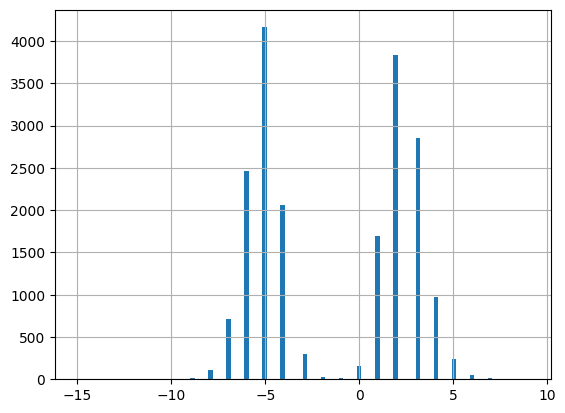

In [26]:
coords.query("condition == \"neural_foraminal_narrowing\"")["distance_from_center"].hist(bins=100)

In [21]:
coords["distance_from_center"].describe()

count    48610.000000
mean        -1.040959
std          6.370783
min        -62.000000
25%         -5.000000
50%         -1.000000
75%          2.000000
max         44.000000
Name: distance_from_center, dtype: float64

In [23]:
coords.loc[coords["distance_from_center"].idxmax(), :]

study_id                                       326589617
series_id                                     1157906303
instance_number                                      133
condition                          subarticular_stenosis
level                                              l1_l2
x                                             285.462259
y                                             289.111785
condition_spec          left_subarticular_stenosis_l1_l2
series_description                              Axial T2
instances_count                                      176
instance_order                                     132.0
distance_from_center                                44.0
Name: 3770, dtype: object